## Time Series value forecasting

- Following model reads main data file and extracts the data we need for problem solving
- We created one time series value forecasting model to forecast the values.
- After forecasting, the values are saved in a '.csv' file to later use in an online application

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Reading main data file

- Reading csv file containing the dataset.

In [2]:
file = pd.read_csv("D:\Study\DPS\monatszahlen2112_verkehrsunfaelle.csv")
file.columns[0:5]

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT'], dtype='object')

### Plotting number of accidents per category

- We use **Summe** for all months to visualize accidents per category which contains accidents per year for every subcategory

In [3]:
sum_ = file.loc[file['MONAT'] == "Summe"]

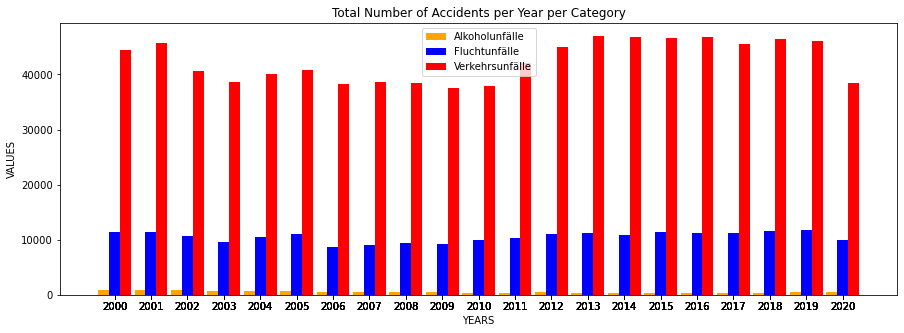

In [4]:
plt.figure(figsize=(15,5))
plt.title("Total Number of Accidents per Year per Category")
plt.bar(sum_.loc[file['MONATSZAHL'] == "Alkoholunfälle"]["JAHR"]-0.3, sum_.loc[file['MONATSZAHL'] == "Alkoholunfälle"]["WERT"] , width = 0.3, label='Alkoholunfälle', color = 'orange')
plt.bar(sum_.loc[file['MONATSZAHL'] == "Fluchtunfälle"]["JAHR"], sum_.loc[file['MONATSZAHL'] == "Fluchtunfälle"]["WERT"] , width = 0.3, label='Fluchtunfälle', color = 'blue')
plt.bar(sum_.loc[file['MONATSZAHL'] == "Verkehrsunfälle"]["JAHR"]+0.3, sum_.loc[file['MONATSZAHL'] == "Verkehrsunfälle"]["WERT"] ,width = 0.3,  label='Verkehrsunfälle', color = 'red')        
plt.xticks(sum_.JAHR)
plt.xlabel("YEARS")
plt.ylabel("VALUES")
plt.legend()
plt.show()

### Dataset for Application of value forecasting

- We take the values for category **Alkoholunfälle** and from that select only type **Insgesamt** to create a dataset for training of our Machine Learning model.
- We excluded total values per year, **Summe** from this dataset

In [5]:
training_data = file.loc[file['MONATSZAHL'] == "Alkoholunfälle" ].loc[file['AUSPRAEGUNG'] == "insgesamt"].loc[file['MONAT'] != "Summe"]
training_data.shape

(264, 9)

In [6]:
training_data.to_csv("TS_Alkohol_Insgesamt.csv")

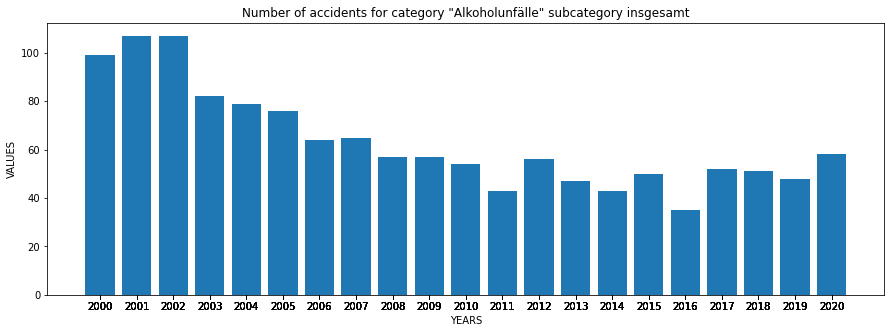

In [7]:
plt.figure(figsize=(15,5))
plt.title('Number of accidents for category "Alkoholunfälle" subcategory insgesamt')
plt.bar(training_data.JAHR, training_data.WERT)
plt.xticks(sum_.JAHR)
plt.xlabel("YEARS")
plt.ylabel("VALUES")
#plt.legend()
plt.show()

### Creating Time Series model to forecast values

- We use file 'TS_Alkohol_Insgesamt.csv' created above for value forecasting.

In [8]:
'''Reading the file'''

file = pd.read_csv("TS_Alkohol_Insgesamt.csv")

### Preprocessing the datafile

In [9]:
file = file.sort_values(by=['MONAT'], ascending=True)

In [10]:
file['YEAR']  = file['MONAT'].apply(lambda x: str(x)[-6:-2])
file['MONTH'] = file['MONAT'].apply(lambda x: str(x)[-2:])
file['ds']    = pd.DatetimeIndex(file['YEAR']+'-'+file['MONTH'], freq='MS')

In [11]:
file.columns

Index(['Unnamed: 0', 'MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT',
       'VORJAHRESWERT', 'VERAEND_VORMONAT_PROZENT',
       'VERAEND_VORJAHRESMONAT_PROZENT', 'ZWOELF_MONATE_MITTELWERT', 'YEAR',
       'MONTH', 'ds'],
      dtype='object')

In [12]:
file.drop(['Unnamed: 0', 'MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'VORJAHRESWERT', 'VERAEND_VORMONAT_PROZENT',
     'VERAEND_VORJAHRESMONAT_PROZENT', 'ZWOELF_MONATE_MITTELWERT', 'YEAR',
      'MONTH'], axis = 1, inplace = True)

In [13]:
'''Setting the year date-time column as index column'''

file.set_index('ds', inplace=True)

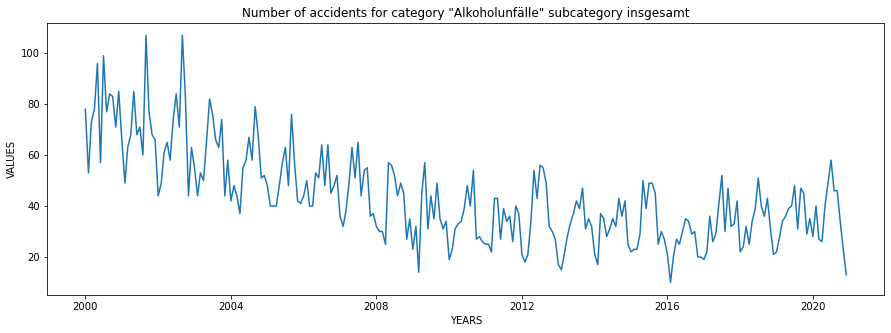

In [14]:
'''Plot to visualise data'''

plt.figure(figsize=(15,5))
plt.title('Number of accidents for category "Alkoholunfälle" subcategory insgesamt')
plt.plot(file)
plt.xticks()
plt.xlabel("YEARS")
plt.ylabel("VALUES")
plt.show()

### SARIMA model

- We use SARIMA model for time series value forecasting

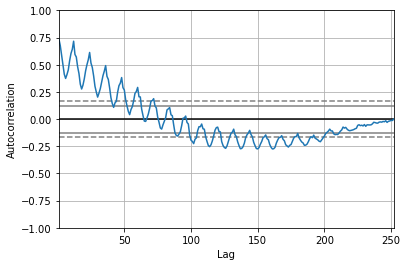

In [15]:
pd.plotting.autocorrelation_plot(file['WERT'].dropna())

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
'''Function to carry out the Augumented-Dickey-Fuller test to get the p value for SARIMA model'''

def adfuller_test(wert):
    result = adfuller(wert)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Rejecting the 'Null Hypothesis'. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, and is non-stationary.")

In [18]:
adfuller_test(file['WERT'].dropna())

ADF Test Statistic : -2.7784740406264907
p-value : 0.06141499421706813
#Lags Used : 13
Number of Observations Used : 238
Weak evidence against null hypothesis, time series has a unit root, and is non-stationary.


####  Finding Difference

- To get p and q values for SARIMA model

In [19]:
file['Difference'] = file['WERT'] - file['WERT'].shift(12) #We Shift by 12 because we have monthly data

In [20]:
adfuller_test(file['Difference'].dropna())

ADF Test Statistic : -3.3587287373519246
p-value : 0.01244889026615171
#Lags Used : 15
Number of Observations Used : 224
Rejecting the 'Null Hypothesis'. Data has no unit root and is stationary.


In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

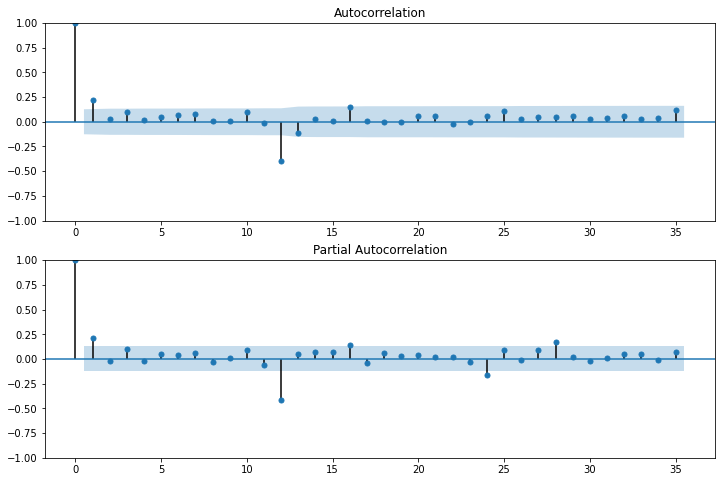

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(file['Difference'].dropna(),lags=35,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(file['Difference'].dropna(),lags=35,ax=ax2, method= 'ywm')

- From above acf and pacf graph we select p=1 and q=1 for our SARIMA model

In [23]:
'''Getting d value for SARIMA model'''

from pmdarima.arima.utils import ndiffs
ndiffs(file.WERT.dropna(), test="adf")

0

### Creating and Training SARIMA model

- p=1, d=0, q=1

In [24]:
import statsmodels.api as sm

In [25]:
model   = sm.tsa.statespace.SARIMAX(file['WERT'],order=(1, 0, 1),seasonal_order=(1,0,1,12), freq='MS')
results = model.fit()

C:\Users\Suyog\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               WERT   No. Observations:                  264
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -904.561
Date:                            Sat, 09 Apr 2022   AIC                           1819.123
Time:                                    21:05:34   BIC                           1837.003
Sample:                                01-01-2000   HQIC                          1826.307
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.005    214.309      0.000       0.988       1.006
ma.L1         -0.8843      0.034    -26.396      0.000      -0.950      -0.819
ar.S.L12       0.9777      0.013     74.101      0.000       0.952       1.004
ma.S.L12      -0.7510      0.069    -10.848      0.000      -0.887      -0.615
sigma2        70.6763      5.844     12.093      0.000      59.222      82.131
===================================================================================
Ljung-Box (L1) (Q):                   2.88   Jarque-Bera (JB):                 4.68
Prob(Q):                              0.09   Prob(JB):                         0.10
Heteroskedasticity (H):               0.52   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

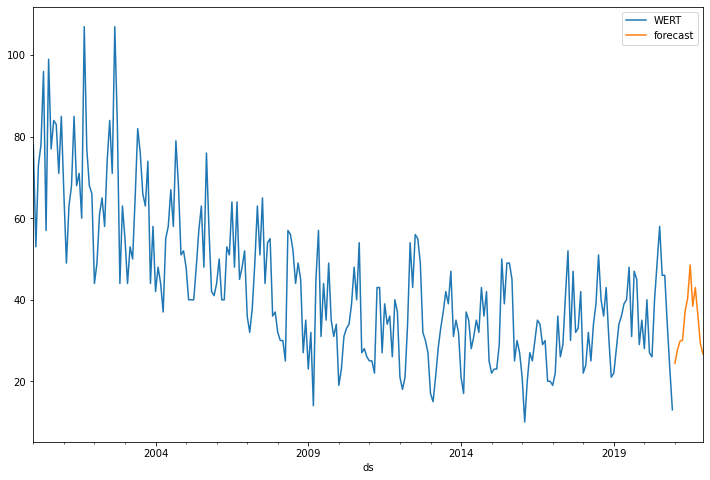

In [27]:
'''Forecasting values using model'''

file['forecast']=results.predict(start=252,end=263,dynamic=True)
file[['WERT','forecast']].plot(figsize=(12,8))

In [28]:
'''Combining old values and Forecasted values in a single dataframe'''

file['Final Values'] = file['WERT'].dropna().combine_first(file['forecast'].dropna()).astype(int)

In [29]:
fvarray            = np.asarray(file['Final Values'])

### Creating new datafile with forecasted values

- We use this file for application to get the predicted values

In [30]:
'''Reading time series file again and preprocessing'''

file_main          = pd.read_csv("D:/Study/DPS/TS_Alkohol_Insgesamt.csv")
file_main          = file_main.sort_values(by=['MONAT'], ascending=True)
file_main['MONTH'] = file_main['MONAT'].apply(lambda x: str(x)[-2:])

In [31]:
file_main.drop(['Unnamed: 0', 'MONATSZAHL', 'MONAT', 'WERT', 'AUSPRAEGUNG', 'VORJAHRESWERT', 'VERAEND_VORMONAT_PROZENT',
     'VERAEND_VORJAHRESMONAT_PROZENT', 'ZWOELF_MONATE_MITTELWERT'], axis = 1, inplace = True)

In [32]:
file_main['FINAL_VALUES'] = fvarray.tolist()

In [33]:
file_main.to_csv("Final_Values.csv", index=False) #Will be used to get forecasted values

In [35]:
file_main

,JAHR,MONTH,FINAL_VALUES
252,2000,01,78
253,2000,02,53
254,2000,03,73
255,2000,04,78
256,2000,05,96
...,...,...,...
7,2021,08,38
8,2021,09,42
9,2021,10,36
10,2021,11,29
